# Pre-Setup

In [0]:
!sudo apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!7z x '/content/drive/My Drive/Datasets/TF_sr/train.7z' 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Datasets/TF_sr/                                                 1 file, 1121103842 bytes (1070 MiB)

Extracting archive: /content/drive/My Drive/Datasets/TF_sr/train.7z
--
Path = /content/drive/My Drive/Datasets/TF_sr/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                               0% 39 - train/audio/_background_noise_/dude

In [0]:
import shutil

shutil.move('/content/train/audio','/content/drive/My Drive/Datasets')

'/content/drive/My Drive/Datasets/audio'

# Exploratory Data Analysis

In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1. Visualization

1.1 Wave and Spectrogram

In [0]:
train_audio_path = '/content/drive/My Drive/Datasets/audio'
file_name = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path)+file_name)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [0]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
  #no. of samples per segment
  nperseg = int(round(window_size*sample_rate/1000))
  #no. of samples per segment-overlap
  noverlap = int(round(step_size*sample_rate/1000))
  freqs, times, spec = signal.spectrogram(audio,fs=sample_rate,window='hann',
                                          nperseg=nperseg,noverlap=noverlap,
                                          detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32)+eps)

Text(0.5, 0, 'Seconds')

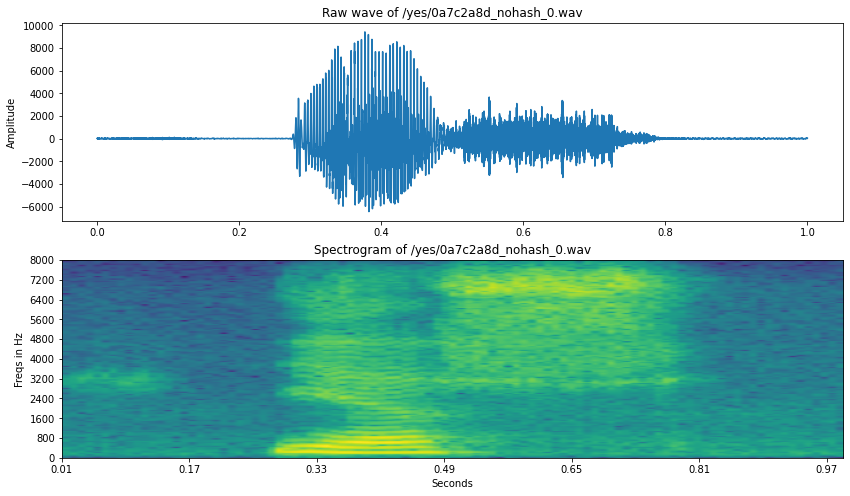

In [5]:
freqs, times, spectrogram= log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' +file_name)
ax1.set_ylabel('Amplitude')
#doubt: i guess it should be len(samples)/sample_rate
ax1.plot(np.linspace(0,sample_rate/len(samples),len(samples)),samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(),freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file_name)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)



In [0]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

1.2 MFCC

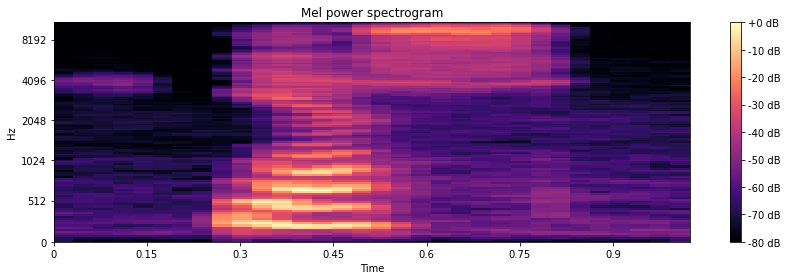

In [7]:
samples1 = np.array(samples.astype(np.float32))
S = librosa.feature.melspectrogram(samples1, sr=sample_rate, n_mels=128)

#convert to log scale(dB) 
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time',y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format = '%+02.0f dB')
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible

1.3 Silence Removal

In [8]:
#lets listen to the audio
ipd.Audio(samples, rate=sample_rate)

VAD (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent VAD can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [9]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

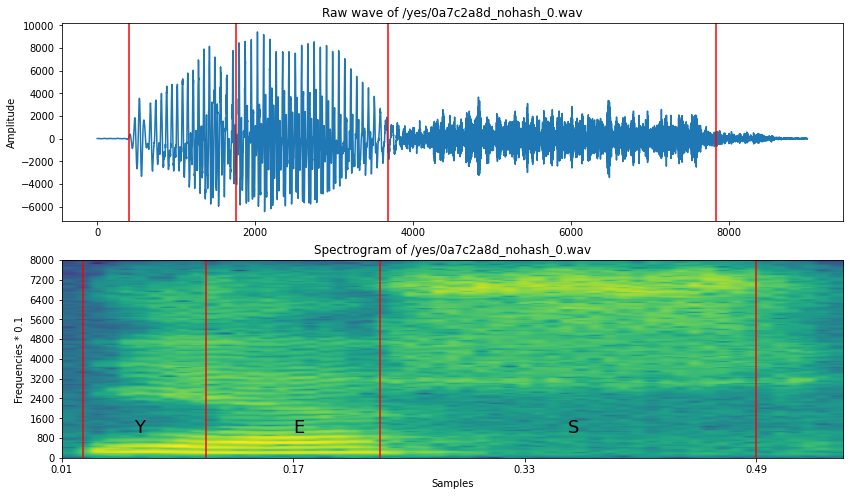

In [10]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_name)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + file_name)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')


1.5 Resampling - dimentionality reduction

We'll need to calculate FFT (Fast Fourier Transform). Definition:

In [0]:
def custom_fft(y, fs):
  T = 1.0/fs
  N = y.shape[0]
  yf = fft(y)
  xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
  vals = 2.0/N*np.abs(yf[0:N//2])
  return xf,vals

In [0]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [13]:
ipd.Audio(samples, rate=sample_rate)

In [14]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

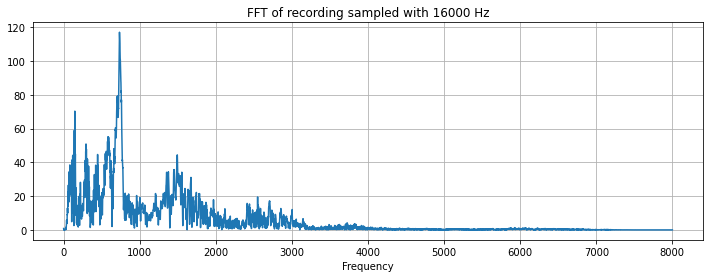

In [15]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

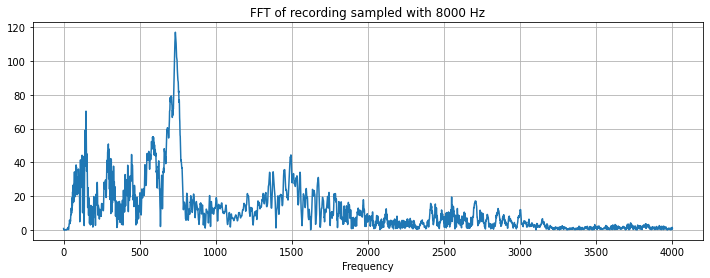

In [16]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!

**2. Dataset investigation**

In [17]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 30


In [0]:
# Calculate
from collections import OrderedDict
number_of_recordings = []
num_of_rec = OrderedDict()
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
    num_of_rec[direct] = len(waves) 

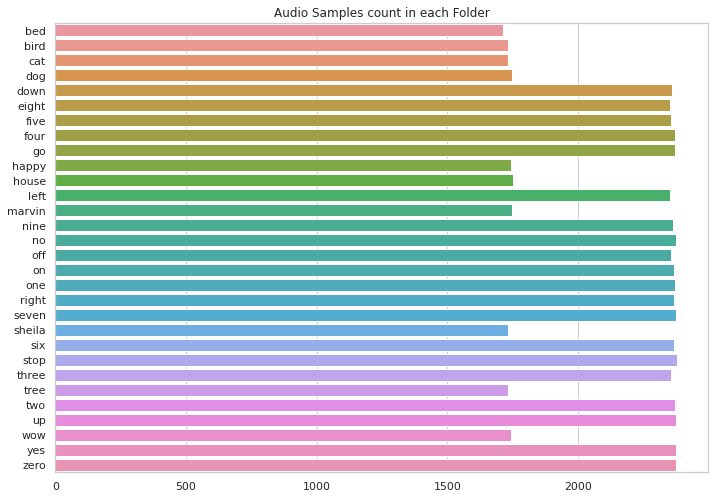

In [19]:
import seaborn as sns

folders = list(num_of_rec.keys())
files = list(num_of_rec.values())
# plt.bar(folders,files,align='center',alpha=0.5)
# plt.xticks(rotation=90)
# plt.show()

sns.set(style='whitegrid',rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x=files, y=folders).set_title('Audio Samples count in each Folder')


Find if all the files have 1 second duration:

In [20]:
total_recordings = 0
for values in num_of_rec.values():
  total_recordings += values

print(total_recordings)

64721


In [0]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/'+direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print(f'Number of recordings shorter than 1 second (out of {total_recordings} waves):{str(num_of_shorter)} ')

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


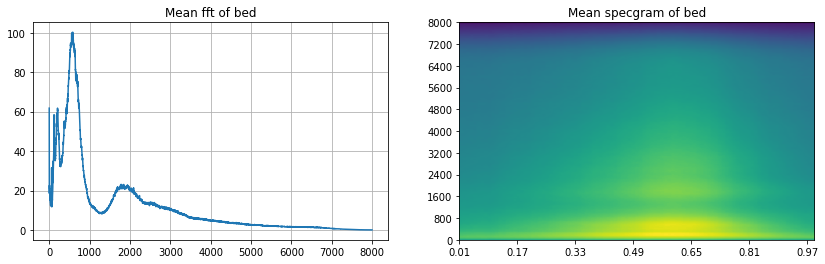

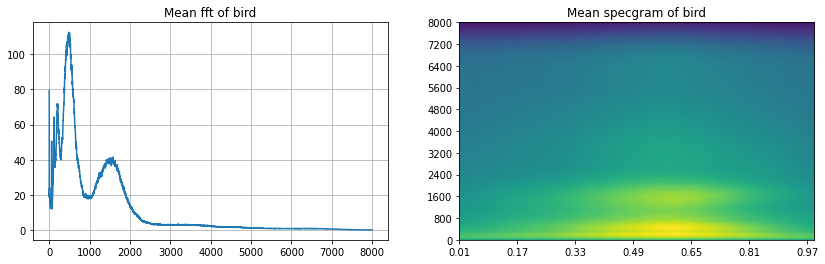

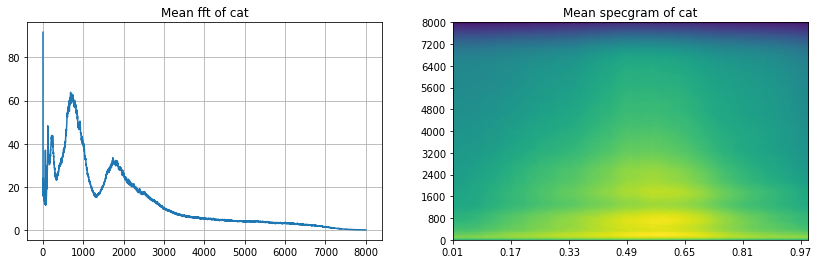

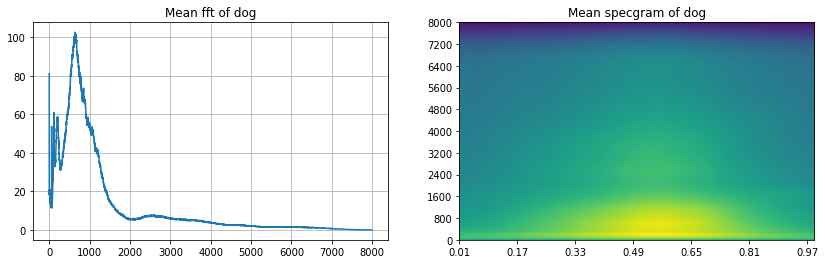

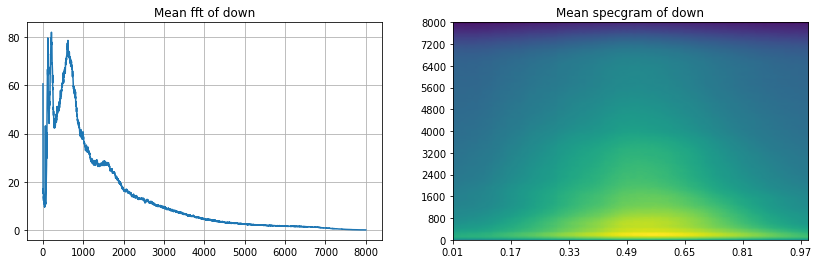

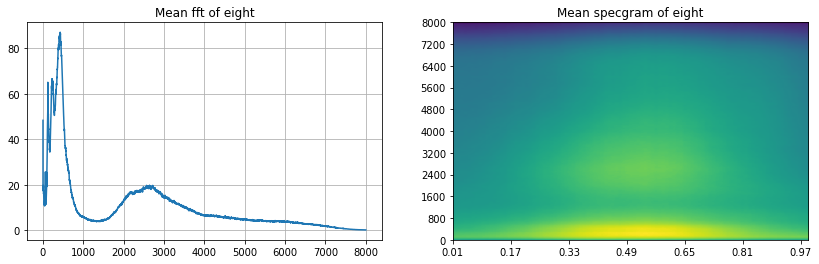

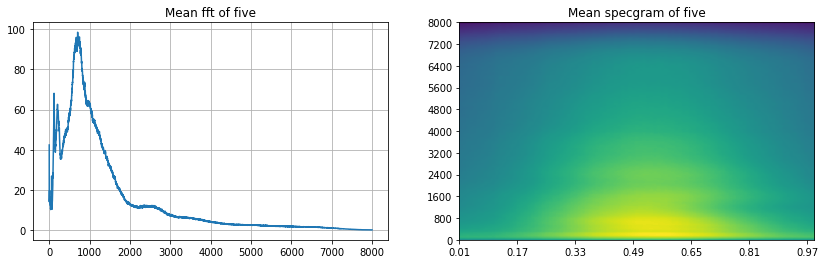

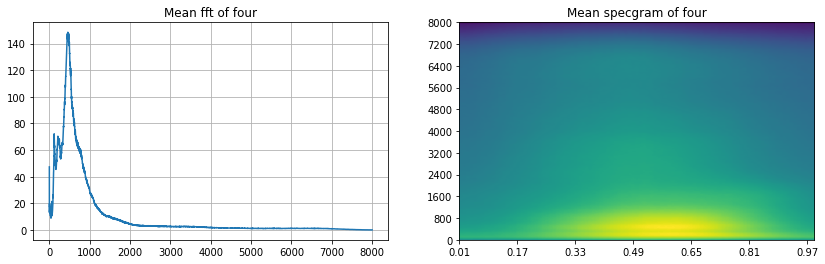

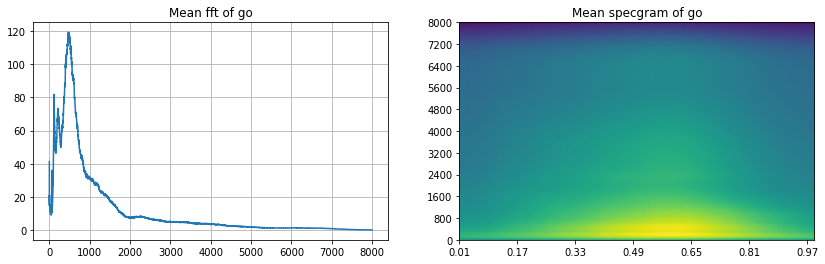

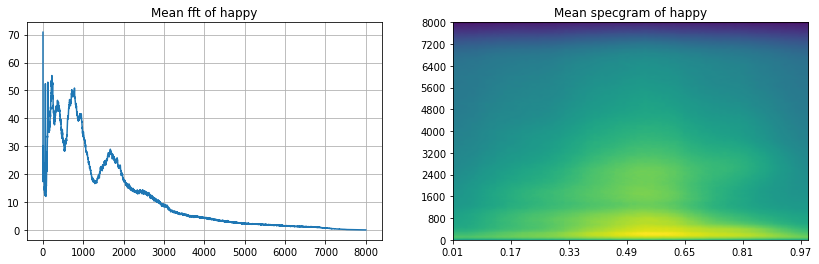

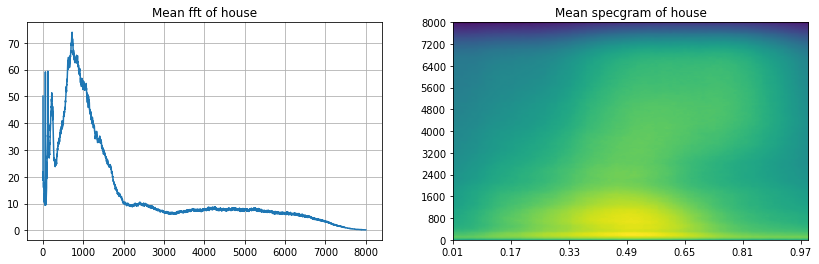

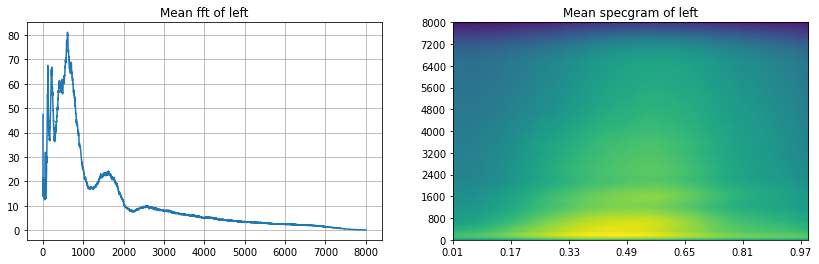

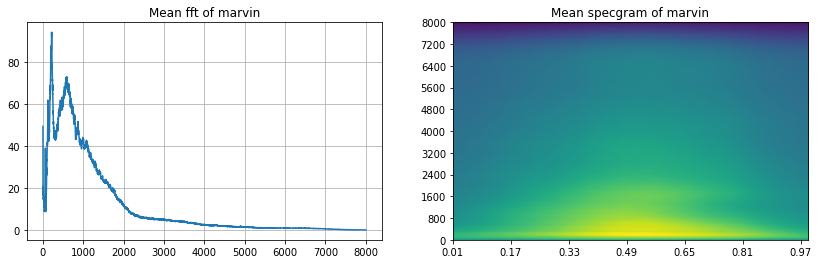

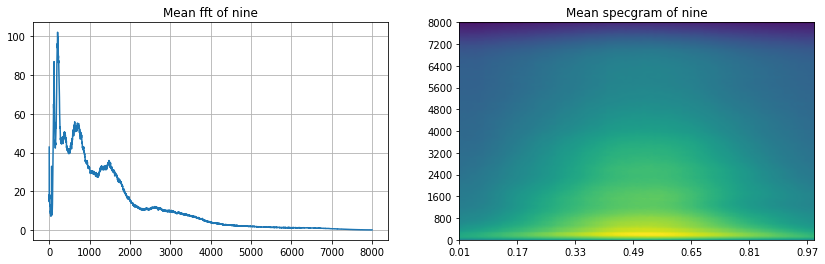

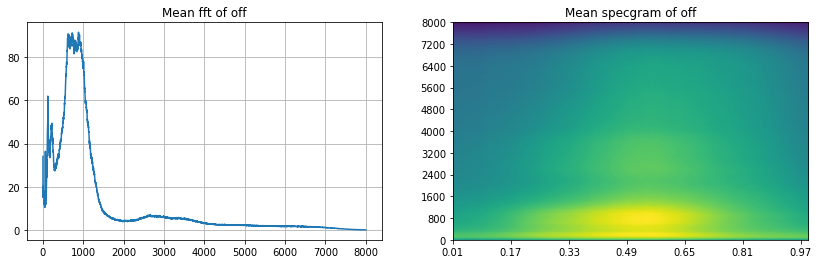

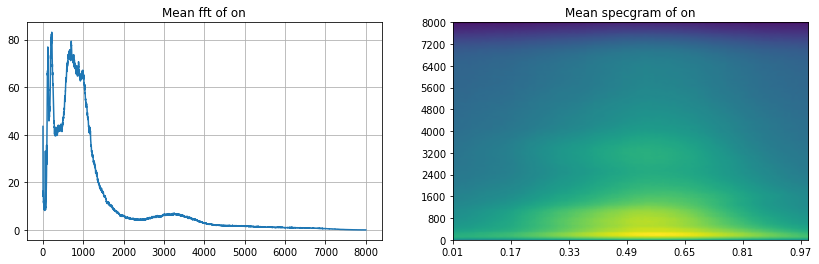

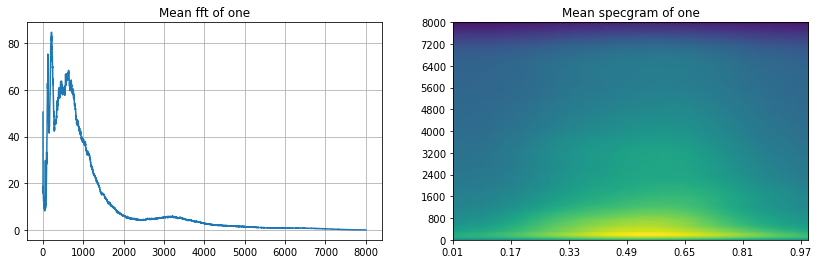

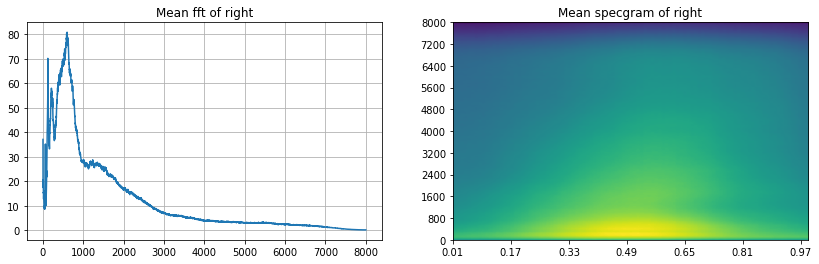

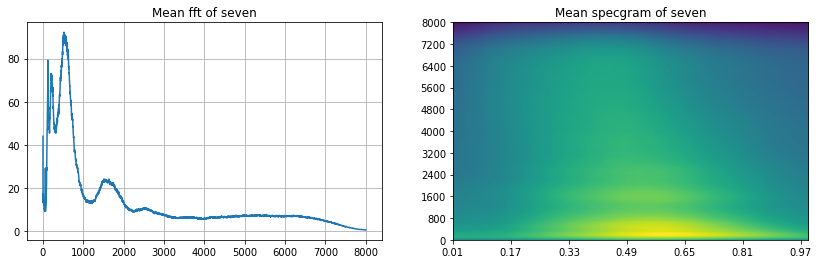

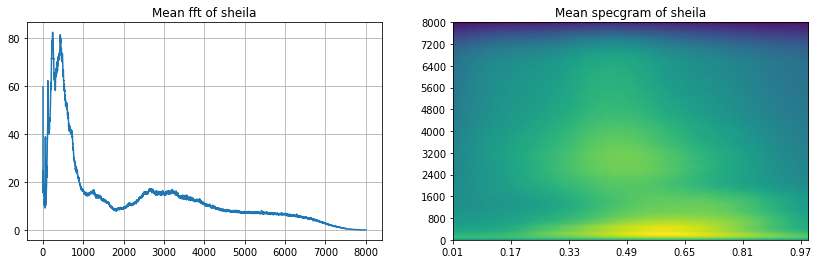

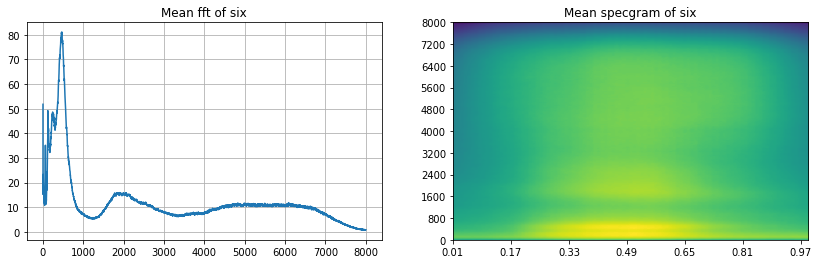

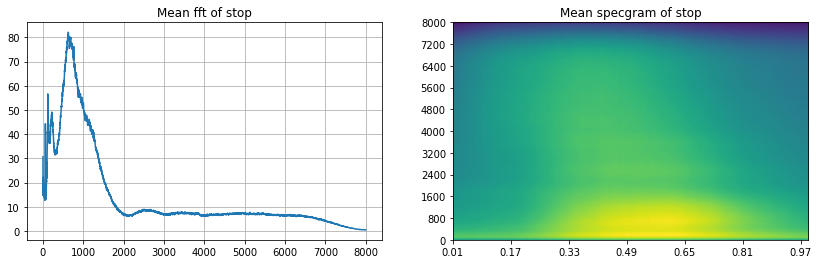

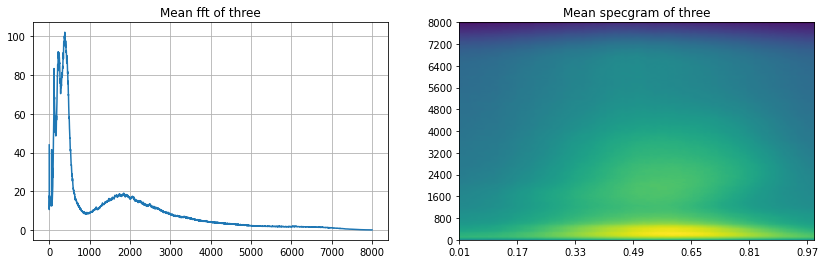

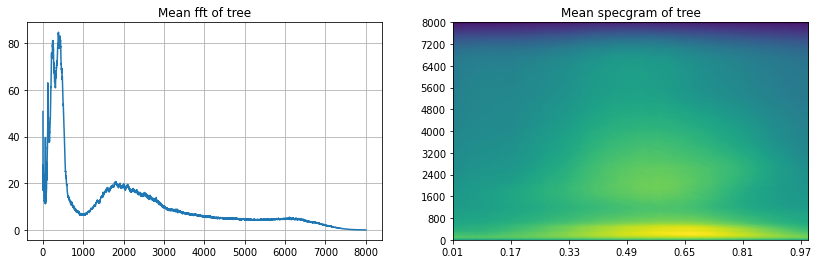

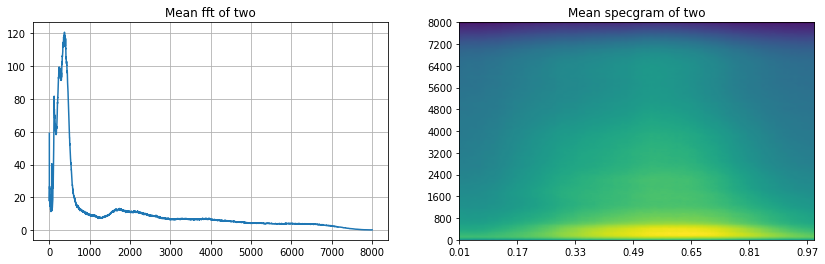

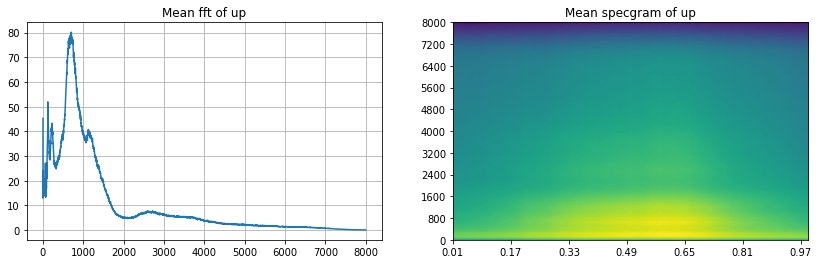

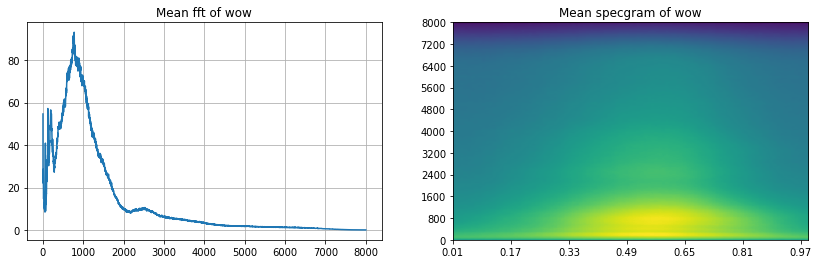

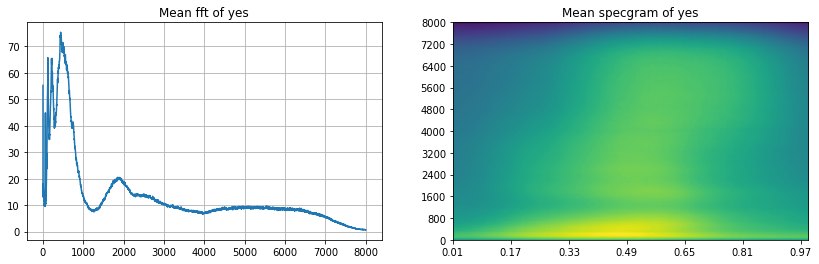

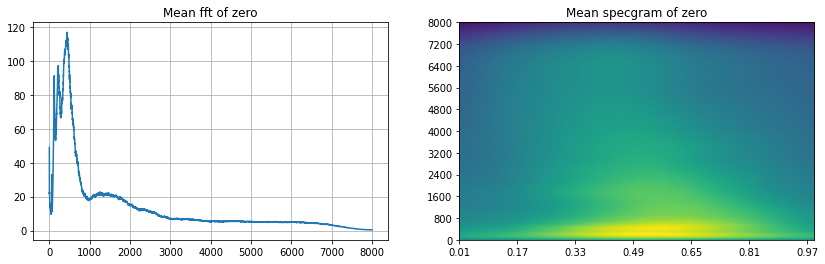

In [0]:
to_keep = 'yes no up down left right on off stop go'.split()
to_not_keep = '_background_noise_'
dirs1 = [d for d in dirs if d not in to_not_keep]

print(dirs1)

for direct in dirs1:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path +'/'+ direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# Feature Extraction

In [0]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=db9e0514453adc3e93ad1317b5859ff8d635676b0c1644076f7cb1e9ee7ffcad
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [0]:
# Dataset path and view possible targets
dataset_path = '/content/drive/My Drive/Datasets/audio'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

left
off
yes
four
marvin
two
zero
six
up
go
one
five
no
seven
sheila
_background_noise_
house
on
bird
cat
right
dog
eight
three
wow
down
happy
stop
tree
bed
nine


In [0]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['left', 'off', 'yes', 'four', 'marvin', 'two', 'zero', 'six', 'up', 'go', 'one', 'five', 'no', 'seven', 'sheila', '_background_noise_', 'house', 'on', 'bird', 'cat', 'right', 'dog', 'eight', 'three', 'wow', 'down', 'happy', 'stop', 'tree', 'bed', 'nine']


In [0]:
len(all_targets)

31

In [0]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

2353
2357
2377
2372
1746
2373
2376
2369
2375
2372
2370
2357
2375
2377
1734
7
1750
2367
1731
1733
2367
1746
2352
2356
1745
2359
1742
2380
1733
1713
2364
Total samples: 64728


In [0]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 0.1 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [0]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/content/drive/My Drive/Datasets/audio/left
/content/drive/My Drive/Datasets/audio/off
/content/drive/My Drive/Datasets/audio/yes
/content/drive/My Drive/Datasets/audio/four
/content/drive/My Drive/Datasets/audio/marvin
/content/drive/My Drive/Datasets/audio/two
/content/drive/My Drive/Datasets/audio/zero
/content/drive/My Drive/Datasets/audio/six
/content/drive/My Drive/Datasets/audio/up
/content/drive/My Drive/Datasets/audio/go
/content/drive/My Drive/Datasets/audio/one
/content/drive/My Drive/Datasets/audio/five
/content/drive/My Drive/Datasets/audio/no
/content/drive/My Drive/Datasets/audio/seven
/content/drive/My Drive/Datasets/audio/sheila
/content/drive/My Drive/Datasets/audio/_background_noise_
/content/drive/My Drive/Datasets/audio/house
/content/drive/My Drive/Datasets/audio/on
/content/drive/My Drive/Datasets/audio/bird
/content/drive/My Drive/Datasets/audio/cat
/content/drive/My Drive/Datasets/audio/right
/content/drive/My Drive/Datasets/audio/dog
/content/drive/My Drive/Da

In [0]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., 15., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [0]:

# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [0]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [0]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

64728
6472


In [0]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [0]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [0]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [0]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [0]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 24 (16, 13)
Dropped: 27 (16, 13)
Dropped: 30 (16, 13)
Dropped: 42 (16, 15)


In [0]:
#!pip install playsound

In [0]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [0]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [0]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

In [0]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [0]:

# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

In [0]:
len(feature_sets['x_train'])

In [0]:
print(feature_sets['y_val'])

# Training the model


In [0]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [0]:
# Settings
feature_sets_path = '/content/drive/My Drive/Datasets/all_targets_mfcc_sets2.npz'
model_filename = 'model.h5'

In [14]:
# Load feature sets
feature_sets = np.load(feature_sets_path)
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [0]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [16]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(47575, 16, 16)
(5953, 16, 16)
(5970, 16, 16)


In [17]:

# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(47575, 16, 16, 1)
(5953, 16, 16, 1)
(5970, 16, 16, 1)


In [18]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [19]:
#one hot encoder
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)


Using TensorFlow backend.


In [20]:
y_train_one_hot[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [0]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32,(2, 2),activation='relu',input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(31, activation='softmax'))

In [55]:
# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [0]:
# Add training parameters to model
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [57]:
x_val[0]

array([[[-4.42356454e+01],
        [-3.78091375e+01],
        [-2.85963623e+01],
        [-1.68686387e+01],
        [-9.82136462e+00],
        [-7.89965554e+00],
        [-8.89267078e+00],
        [-1.19755147e+01],
        [-1.94975376e+01],
        [-2.79640881e+01],
        [-3.18065941e+01],
        [-3.47757813e+01],
        [-4.05244435e+01],
        [-4.85481620e+01],
        [-5.71938904e+01],
        [-6.41538668e+01]],

       [[ 2.09238047e+01],
        [ 2.36421872e+01],
        [ 2.09532166e+01],
        [ 1.39766729e+01],
        [ 7.42665433e+00],
        [ 2.50137495e+00],
        [-1.68515419e-01],
        [-1.17081237e-01],
        [ 5.00207482e-01],
        [ 1.11380632e+00],
        [-3.11504727e+00],
        [-5.21013047e+00],
        [-5.20491662e+00],
        [-2.13955075e+00],
        [ 2.12164026e+00],
        [ 5.50317606e+00]],

       [[-3.41197803e+00],
        [-3.15648868e+00],
        [-5.01847128e+00],
        [-7.39177296e+00],
        [-6.37125168e+00

In [58]:
# Train
history = model.fit(x_train, 
                    y_train_one_hot, 
                    epochs=50, 
                    batch_size=100, 
                    validation_data=(x_val, y_val_one_hot))

Epoch 1/50
476/476 [==============================] - 3s 7ms/step - loss: 2.8500 - accuracy: 0.1795 - val_loss: 1.9779 - val_accuracy: 0.4551
Epoch 2/50
476/476 [==============================] - 3s 7ms/step - loss: 2.0592 - accuracy: 0.3773 - val_loss: 1.5600 - val_accuracy: 0.5533
Epoch 3/50
476/476 [==============================] - 3s 7ms/step - loss: 1.7696 - accuracy: 0.4651 - val_loss: 1.4233 - val_accuracy: 0.5821
Epoch 4/50
476/476 [==============================] - 3s 7ms/step - loss: 1.6033 - accuracy: 0.5159 - val_loss: 1.3166 - val_accuracy: 0.6212
Epoch 5/50
476/476 [==============================] - 3s 7ms/step - loss: 1.4787 - accuracy: 0.5536 - val_loss: 1.1165 - val_accuracy: 0.6743
Epoch 6/50
476/476 [==============================] - 3s 7ms/step - loss: 1.3789 - accuracy: 0.5831 - val_loss: 1.0521 - val_accuracy: 0.6960
Epoch 7/50
476/476 [==============================] - 3s 7ms/step - loss: 1.3024 - accuracy: 0.6048 - val_loss: 1.0055 - val_accuracy: 0.7007
Epoch 

In [0]:
models.save_model(model,filepath='model1_2.h5')

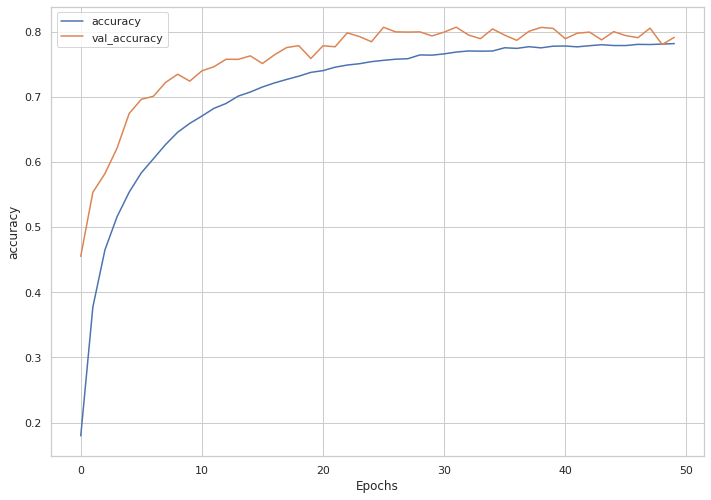

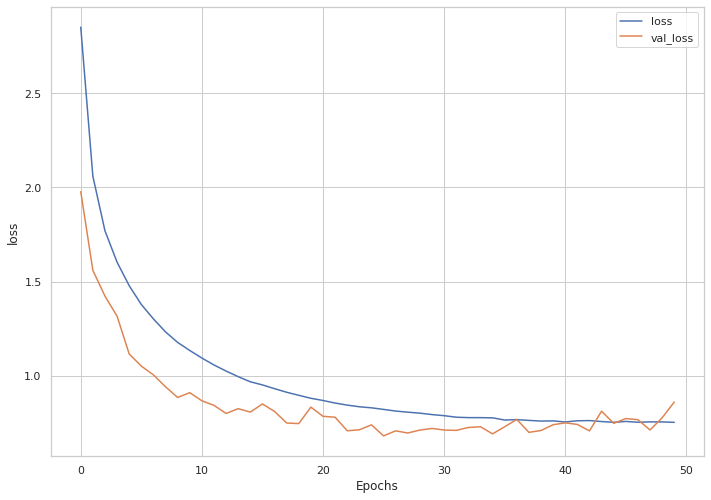

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid',rc={'figure.figsize':(11.7,8.27)})


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Testing the Model

In [0]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/My Drive/Datasets/model1_2.h5')

**1. Confusion Matrix**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


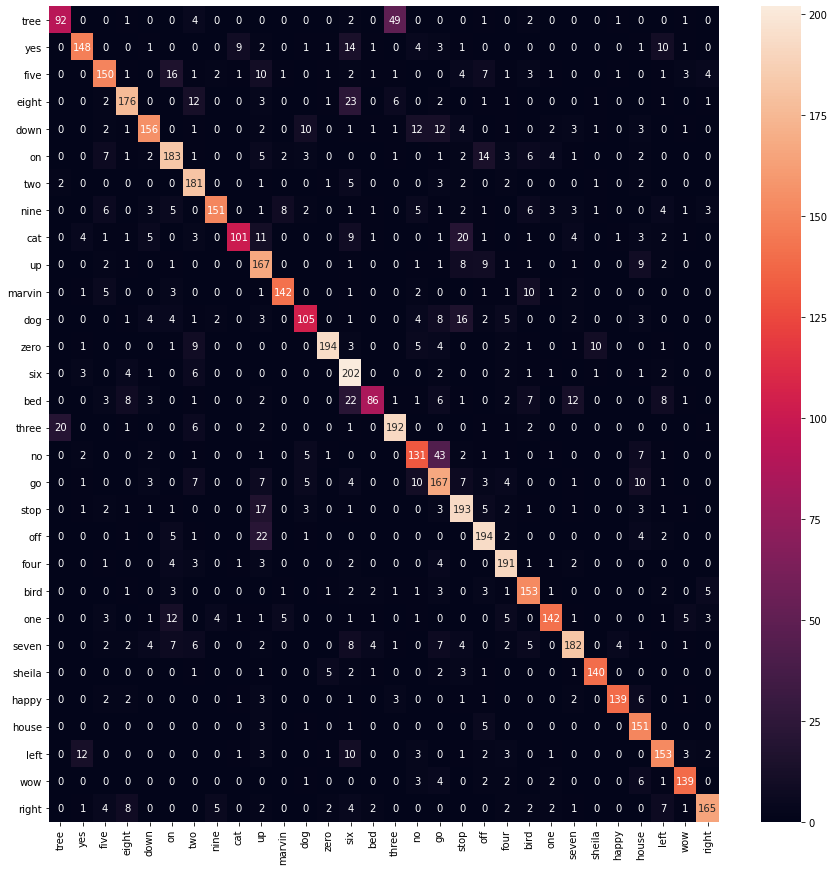

In [22]:
import numpy as np

ypred = np.argmax(model.predict(x_test), axis=-1)

from sklearn.metrics import confusion_matrix

con_mat = confusion_matrix(y_test, ypred)

with open('/content/drive/My Drive/Datasets/output.json','r') as f:
    output = json.load(f)

class_names = list(output.values())
class_names.remove('_background_noise_')

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(con_mat, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (15,15))
sns_plot = sn.heatmap(df_cm, annot=True,fmt='d')
plt.savefig("output.png")

**2. Classification Report**

In [23]:
from sklearn.metrics import classification_report

report = classification_report(y_test, ypred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.60      0.69       153
         1.0       0.85      0.75      0.80       197
         2.0       0.78      0.71      0.74       212
         3.0       0.83      0.77      0.80       230
         4.0       0.84      0.73      0.78       214
         5.0       0.75      0.77      0.76       238
         6.0       0.74      0.91      0.81       200
         7.0       0.92      0.73      0.81       208
         8.0       0.88      0.59      0.71       170
         9.0       0.61      0.81      0.70       205
        11.0       0.89      0.84      0.86       170
        12.0       0.77      0.65      0.70       161
        13.0       0.93      0.84      0.88       232
        14.0       0.62      0.89      0.73       226
        15.0       0.85      0.52      0.65       164
        16.0       0.75      0.85      0.80       227
        17.0       0.72      0.66      0.69       199
        18.0       0.60    

# Predicting using the model

In [36]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=1462f33cfcc12bdb9d568d696ce226ee9ebb7d1268349bb98053541efaf1e4db
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
import IPython.display as ipd
from scipy.io import wavfile
import librosa
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import json
import tensorflow as tf

In [0]:
with open('/content/drive/My Drive/Datasets/output.json','r') as f:
    output = json.load(f)

In [0]:
model = tf.keras.models.load_model('/content/drive/My Drive/Datasets/model1_2.h5')
audio = '/content/drive/My Drive/Datasets/audio/bird/00b01445_nohash_0.wav'
sample_rate, samples = wavfile.read(audio)

In [5]:
ipd.Audio(samples, rate=sample_rate)

In [0]:
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [0]:
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=sample_rate,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

# Function: Create MFCCs, keeping only ones of desired length
def extract_features(path):

    out_x = []
        
    # Create MFCCs
    mfccs = calc_mfcc(path)

    # Only keep MFCCs with given length
    if mfccs.shape[1] == len_mfcc:
        out_x.append(mfccs)
     
    else:
        print('Dropped:', index, mfccs.shape)
     
            
    return out_x

In [0]:
x = extract_features(audio)
x = x[0].reshape(1,x[0].shape[0],x[0].shape[1],1)

In [9]:
classes = np.argmax(model.predict(x), axis=-1)
print(output[str(classes[0])])

bird
